<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch11_training_deep_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11 — Training Deep Neural Networks

## 1) Summary
In this chapter, I focus on the practical problems that appear when neural networks become deep, and the techniques used to train them reliably.

What I reproduce and explain in this notebook:
- Why deep networks can be hard to train (vanishing/exploding gradients, unstable updates).
- Better defaults for deep MLPs:
  - sensible **weight initialization** (Glorot / He / LeCun),
  - **non-saturating activation functions** (ReLU family, ELU/SELU),
  - **Batch Normalization**,
  - **gradient clipping**.
- Reusing and fine-tuning pre-trained networks (transfer learning workflow).
- Optimizers and training strategies that usually speed up convergence:
  - SGD + momentum / Nesterov,
  - RMSProp / Adam,
  - learning-rate scheduling and callbacks.
- Regularization commonly used for deep nets (L2 weight decay, dropout, max-norm).

## 2) Learning Goals
- Train deep networks without unstable training.
- Pick reasonable initializers/activations for MLPs.
- Add BatchNorm and interpret its impact on learning curves.
- Use gradient clipping to stabilize training.
- Compare optimizers quickly and read training curves.
- Apply a clean transfer learning workflow (freeze → train head → unfreeze → fine-tune).

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 3) Dataset Setup (Fashion MNIST)

I use Fashion MNIST because:
- It is small and fast to run.
- It is multiclass (10 classes) and works well for comparing training setups.
- It is the same dataset used in earlier chapters, so differences in training behavior are easier to attribute to the training technique.

Workflow:
1. Load data
2. Scale to [0, 1]
3. Split train/validation

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_train.shape, X_valid.shape, X_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

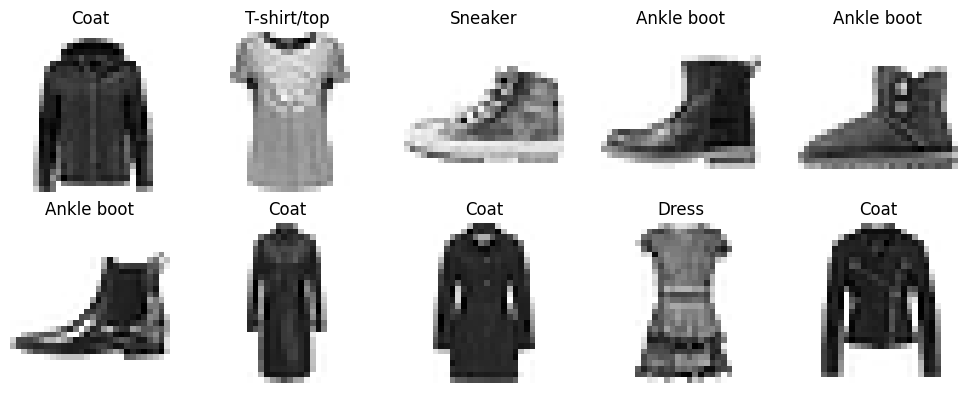

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap="binary")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4) A reusable training helper

To keep experiments comparable, I use:
- the same data splits
- the same number of epochs (small for speed)
- the same evaluation on validation/test

I also plot training curves after each run.

In [4]:
def compile_and_fit(model, X_train, y_train, X_valid, y_valid,
                    optimizer, epochs=10, batch_size=64, verbose=0,
                    callbacks=None):
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks or [],
        verbose=verbose
    )
    return history

def plot_history(history, title):
    df = pd.DataFrame(history.history)
    ax = df[["loss", "val_loss"]].plot(figsize=(8, 4), grid=True, title=title + " — loss")
    plt.show()
    ax = df[["accuracy", "val_accuracy"]].plot(figsize=(8, 4), grid=True, title=title + " — accuracy")
    plt.ylim(0, 1)
    plt.show()

def evaluate_model(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    return {"test_loss": float(loss), "test_accuracy": float(acc)}

# Part A — Why training deep nets can be hard

## 5) Vanishing gradients intuition (short demo)
Saturating activations (like sigmoid/tanh) can produce very small gradients when activations saturate.
In deep networks, these small gradients can shrink layer by layer (vanishing gradients), making learning slow for early layers.

In this notebook I demonstrate a practical observation:
- a deep MLP with **sigmoid** trains slower than a similar model with **ReLU + He initialization**.

This is not a proof; it is an empirical check using the same dataset and training budget.

In [5]:
def build_deep_mlp(activation, initializer, n_hidden=10, n_neurons=100):
    layers = [keras.layers.Input(shape=(28, 28)), keras.layers.Flatten()]
    for _ in range(n_hidden):
        layers.append(keras.layers.Dense(n_neurons, activation=activation,
                                        kernel_initializer=initializer))
    layers.append(keras.layers.Dense(10, activation="softmax"))
    return keras.models.Sequential(layers)

# Deep MLP with sigmoid + Glorot (default)
sigmoid_model = build_deep_mlp(
    activation="sigmoid",
    initializer="glorot_uniform",
    n_hidden=10,
    n_neurons=100
)

# Deep MLP with ReLU + He init
relu_he_model = build_deep_mlp(
    activation="relu",
    initializer="he_normal",
    n_hidden=10,
    n_neurons=100
)

sigmoid_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,410 (665.66 KB)

 Trainable params: 170,410 (665.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0987 - loss: 2.3153 - val_accuracy: 0.1008 - val_loss: 2.3039
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0994 - loss: 2.3039 - val_accuracy: 0.1008 - val_loss: 2.3039
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0994 - loss: 2.3039 - val_accuracy: 0.1008 - val_loss: 2.3039
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0991 - loss: 2.3039 - val_accuracy: 0.1008 - val_loss: 2.3039
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0991 - loss: 2.3039 - val_accuracy: 0.1008 - val_loss: 2.3039


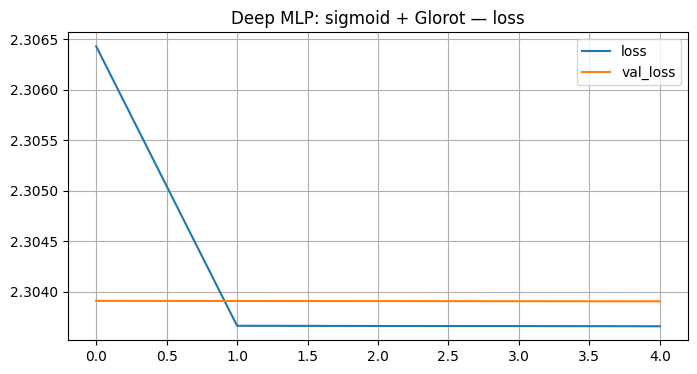

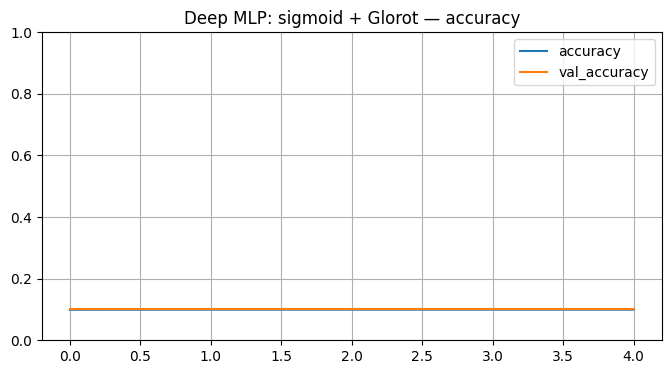

In [6]:
# Keep epochs small to make it quick to run in Colab
hist_sigmoid = compile_and_fit(
    sigmoid_model, X_train, y_train, X_valid, y_valid,
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    epochs=5,
    verbose=1
)
plot_history(hist_sigmoid, "Deep MLP: sigmoid + Glorot")

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5957 - loss: 1.1308 - val_accuracy: 0.6416 - val_loss: 0.9596
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8132 - loss: 0.5182 - val_accuracy: 0.7510 - val_loss: 0.6681
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8386 - loss: 0.4413 - val_accuracy: 0.7906 - val_loss: 0.5503
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8533 - loss: 0.4018 - val_accuracy: 0.7904 - val_loss: 0.5417
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8624 - loss: 0.3775 - val_accuracy: 0.8096 - val_loss: 0.4895


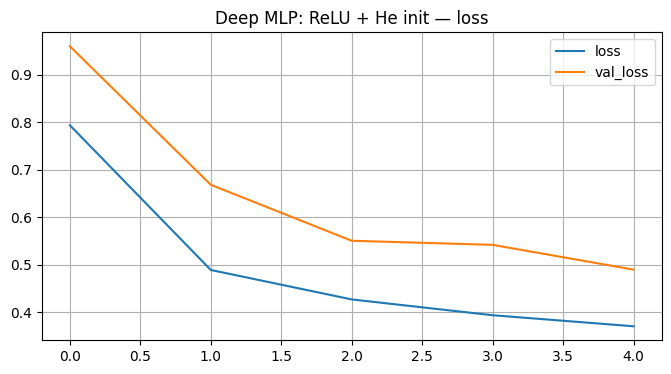

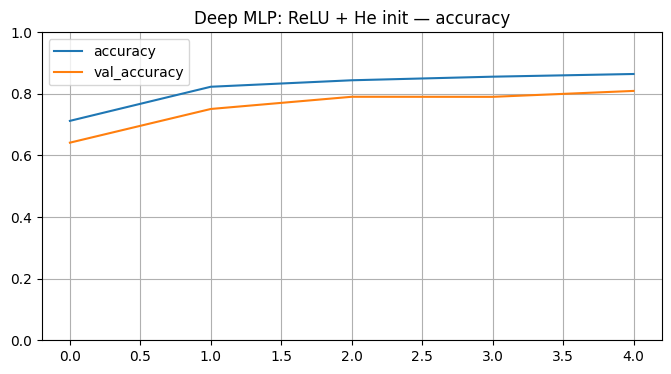

In [7]:
hist_relu_he = compile_and_fit(
    relu_he_model, X_train, y_train, X_valid, y_valid,
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    epochs=5,
    verbose=1
)
plot_history(hist_relu_he, "Deep MLP: ReLU + He init")

**Checkpoint note (what I look for):**
- If ReLU + He reaches a better validation accuracy faster under the same budget, it supports the idea that better defaults reduce training difficulties.

# Part B — Activation Functions for Deep Networks

## 6) ReLU family vs ELU/SELU (practical view)
Common choices for hidden layers:
- ReLU: simple and fast; can suffer from "dying ReLU" in some settings.
- LeakyReLU: small slope for negative inputs (reduces dead units risk).
- ELU: smooth negative region; can help convergence sometimes.
- SELU: used for self-normalizing networks (typically with LeCun init + AlphaDropout).

Below I compare a small set quickly (few epochs each).

In [8]:
def build_mlp_with_custom_activation(activation_layer, initializer="he_normal", n_hidden=5, n_neurons=100):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer=initializer))
        model.add(activation_layer)
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

# ReLU baseline
relu_model = build_deep_mlp("relu", "he_normal", n_hidden=5, n_neurons=100)

# LeakyReLU
leaky_model = build_mlp_with_custom_activation(
    keras.layers.LeakyReLU(alpha=0.1),
    initializer="he_normal",
    n_hidden=5,
    n_neurons=100
)

# ELU
elu_model = build_mlp_with_custom_activation(
    keras.layers.ELU(alpha=1.0),
    initializer="he_normal",
    n_hidden=5,
    n_neurons=100
)

models = {
    "ReLU": relu_model,
    "LeakyReLU": leaky_model,
    "ELU": elu_model
}

results_activation = []
for name, m in models.items():
    h = compile_and_fit(
        m, X_train, y_train, X_valid, y_valid,
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        epochs=3,
        verbose=0
    )
    val_acc = float(h.history["val_accuracy"][-1])
    results_activation.append((name, val_acc))

pd.DataFrame(results_activation, columns=["activation", "val_accuracy_after_3_epochs"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


,activation,val_accuracy_after_3_epochs
0,ReLU,0.8092
1,LeakyReLU,0.8168
2,ELU,0.8308


Interpretation:
- This table is a quick sanity check, not a final benchmark.
- The point is to practice swapping activations and observing training behavior.

# Part C — Batch Normalization

## 7) Why BatchNorm?
Batch Normalization (BatchNorm) normalizes intermediate activations and learns scale/shift parameters.
In practice, BatchNorm often:
- stabilizes training,
- allows higher learning rates,
- reduces sensitivity to initialization,
- acts as mild regularization.

Implementation pattern (MLP):
Dense -> BatchNorm -> Activation

In [9]:
def build_bn_mlp(n_hidden=5, n_neurons=100, initializer="he_normal"):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer=initializer, use_bias=False))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

bn_model = build_bn_mlp(n_hidden=5, n_neurons=100)
bn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 100)            │        78,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 100)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 100)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 100)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,410 (474.26 KB)

 Trainable params: 120,410 (470.35 KB)

 Non-trainable params: 1,000 (3.91 KB)

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7547 - loss: 0.7359 - val_accuracy: 0.8452 - val_loss: 0.4160
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8587 - loss: 0.3920 - val_accuracy: 0.8592 - val_loss: 0.3745
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8803 - loss: 0.3363 - val_accuracy: 0.8626 - val_loss: 0.3612
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8905 - loss: 0.3021 - val_accuracy: 0.8690 - val_loss: 0.3602
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9012 - loss: 0.2746 - val_accuracy: 0.8694 - val_loss: 0.3535


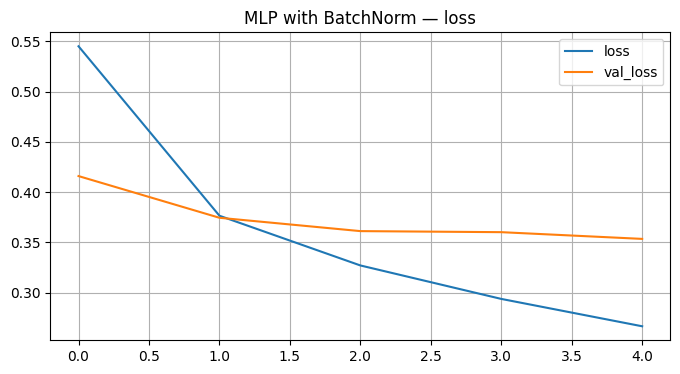

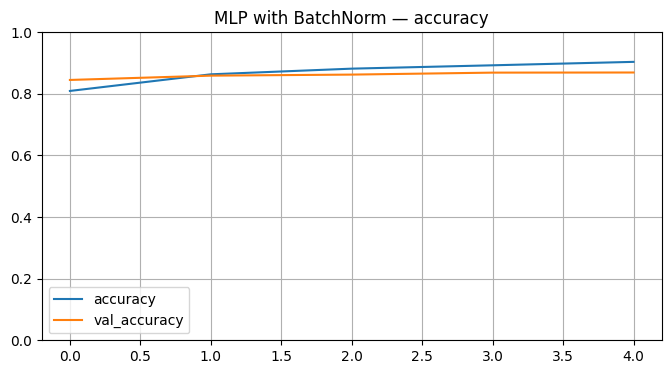

In [10]:
hist_bn = compile_and_fit(
    bn_model, X_train, y_train, X_valid, y_valid,
    optimizer=keras.optimizers.SGD(learning_rate=0.05),  # often can use higher LR with BN
    epochs=5,
    verbose=1
)
plot_history(hist_bn, "MLP with BatchNorm")

# Part D — Gradient Clipping

## 8) Why clip gradients?
Exploding gradients can cause unstable updates (especially in deep nets or RNNs).
A practical fix is to clip gradients:
- `clipnorm`: clip by global norm
- `clipvalue`: clip each component

Below I show how to enable clipping in the optimizer.

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6345 - loss: 0.9927 - val_accuracy: 0.7926 - val_loss: 0.5845
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8208 - loss: 0.4849 - val_accuracy: 0.7990 - val_loss: 0.5553
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8445 - loss: 0.4154 - val_accuracy: 0.8116 - val_loss: 0.5242
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8588 - loss: 0.3772 - val_accuracy: 0.8268 - val_loss: 0.5051
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8684 - loss: 0.3522 - val_accuracy: 0.8434 - val_loss: 0.4452


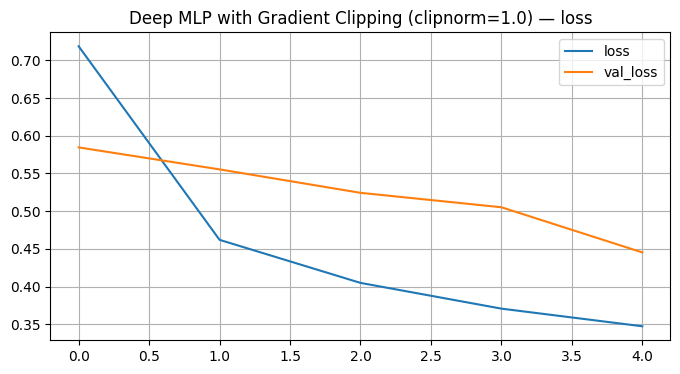

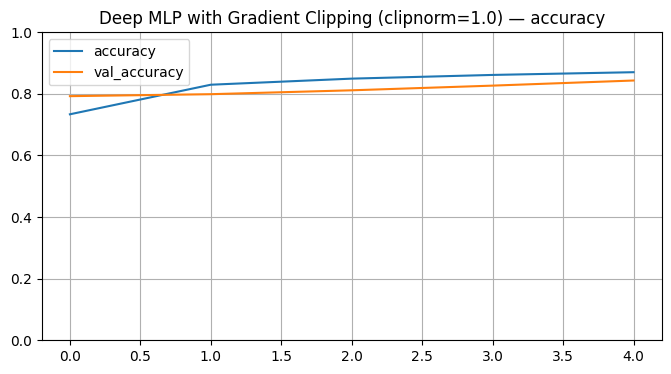

In [11]:
clip_model = build_deep_mlp("relu", "he_normal", n_hidden=10, n_neurons=100)

optimizer_with_clipping = keras.optimizers.SGD(learning_rate=0.05, clipnorm=1.0)

hist_clip = compile_and_fit(
    clip_model, X_train, y_train, X_valid, y_valid,
    optimizer=optimizer_with_clipping,
    epochs=5,
    verbose=1
)
plot_history(hist_clip, "Deep MLP with Gradient Clipping (clipnorm=1.0)")

# Part E — Transfer Learning (Reuse and Fine-tune)

## 9) Transfer learning workflow used in practice
1. Train a base model on a source task (or load a pretrained model).
2. Replace the output layer for the new task.
3. Freeze the base layers and train only the new head.
4. Optionally unfreeze the top layers and fine-tune with a smaller learning rate.

Here I simulate this workflow using Fashion MNIST:
- Source task: full 10-class classification.
- Target task: binary classification (Sneaker vs Ankle boot).

In [12]:
def make_binary_fashion_mnist(X, y, class_a=7, class_b=9):
    mask = (y == class_a) | (y == class_b)
    X_bin = X[mask]
    y_bin = y[mask]
    y_bin = (y_bin == class_b).astype(np.int32)  # class_b -> 1, class_a -> 0
    return X_bin, y_bin

X_train_bin, y_train_bin = make_binary_fashion_mnist(X_train_full, y_train_full, 7, 9)
X_test_bin, y_test_bin = make_binary_fashion_mnist(X_test, y_test, 7, 9)

X_valid_bin, X_train_bin = X_train_bin[:1000], X_train_bin[1000:]
y_valid_bin, y_train_bin = y_train_bin[:1000], y_train_bin[1000:]

X_train_bin.shape, X_valid_bin.shape, X_test_bin.shape

((11000, 28, 28), (1000, 28, 28), (2000, 28, 28))

In [13]:
# 9.1 Train a base model on the 10-class task (short run for demonstration)
base_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

base_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

_ = base_model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7052 - loss: 0.9402 - val_accuracy: 0.8288 - val_loss: 0.5040
Epoch 2/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8296 - loss: 0.4897 - val_accuracy: 0.8494 - val_loss: 0.4421
Epoch 3/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8461 - loss: 0.4392 - val_accuracy: 0.8596 - val_loss: 0.4093


In [14]:
# 9.2 Build a new model that reuses the base layers (except the original head)
# We reuse the first layers and attach a new binary head.
reused_layers = base_model.layers[:-1]  # drop final softmax head

transfer_model = keras.models.Sequential()
transfer_model.add(keras.layers.Input(shape=(28, 28)))
for layer in reused_layers:
    transfer_model.add(layer)

transfer_model.add(keras.layers.Dense(1, activation="sigmoid"))  # binary head

# Freeze reused layers
for layer in reused_layers:
    layer.trainable = False

transfer_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.02),
    metrics=["accuracy"]
)

transfer_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,701 (1.01 MB)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 265,600 (1.01 MB)

In [15]:
# Train only the new head
hist_transfer = transfer_model.fit(
    X_train_bin, y_train_bin,
    epochs=5,
    validation_data=(X_valid_bin, y_valid_bin),
    verbose=1
)

pd.DataFrame(hist_transfer.history)[["loss", "val_loss", "accuracy", "val_accuracy"]].tail()

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9063 - loss: 0.2747 - val_accuracy: 0.9530 - val_loss: 0.1307
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9509 - loss: 0.1413 - val_accuracy: 0.9560 - val_loss: 0.1197
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9528 - loss: 0.1344 - val_accuracy: 0.9580 - val_loss: 0.1149
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9541 - loss: 0.1312 - val_accuracy: 0.9580 - val_loss: 0.1119
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9554 - loss: 0.1290 - val_accuracy: 0.9580 - val_loss: 0.1096


,loss,val_loss,accuracy,val_accuracy
0,0.192139,0.130722,0.938818,0.953
1,0.136805,0.119735,0.952455,0.956
2,0.130804,0.114930,0.954364,0.958
3,0.127628,0.111874,0.955182,0.958
4,0.125403,0.109649,0.956273,0.958


In [16]:
# 9.3 Fine-tune: unfreeze top reused layer(s) and train with smaller LR
for layer in reused_layers[-1:]:
    layer.trainable = True

transfer_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    metrics=["accuracy"]
)

hist_finetune = transfer_model.fit(
    X_train_bin, y_train_bin,
    epochs=5,
    validation_data=(X_valid_bin, y_valid_bin),
    verbose=1
)

pd.DataFrame(hist_finetune.history)[["loss", "val_loss", "accuracy", "val_accuracy"]].tail()

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9561 - loss: 0.1270 - val_accuracy: 0.9610 - val_loss: 0.1075
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9570 - loss: 0.1248 - val_accuracy: 0.9610 - val_loss: 0.1059
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9571 - loss: 0.1231 - val_accuracy: 0.9630 - val_loss: 0.1045
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9582 - loss: 0.1216 - val_accuracy: 0.9650 - val_loss: 0.1032
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9584 - loss: 0.1203 - val_accuracy: 0.9650 - val_loss: 0.1021


,loss,val_loss,accuracy,val_accuracy
0,0.123182,0.107501,0.957000,0.961
1,0.121108,0.105866,0.957727,0.961
2,0.119422,0.104469,0.958091,0.963
3,0.117952,0.103202,0.959273,0.965
4,0.116624,0.102083,0.959455,0.965


In [17]:
# Evaluate on binary test set
bin_loss, bin_acc = transfer_model.evaluate(X_test_bin, y_test_bin, verbose=0)
bin_loss, bin_acc

(0.12053091824054718, 0.9539999961853027)

# Part F — Optimizers and Training Speed

## 10) Quick optimizer comparison
This section is a small, controlled comparison to practice switching optimizers.
I compare a few common optimizers for a few epochs:
- SGD
- SGD + momentum (classic improvement)
- Adam (strong default in many projects)

The goal is not to declare a universal winner, but to practice the workflow and interpret learning curves.

In [18]:
def build_baseline_classifier():
    return keras.models.Sequential([
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])

optimizers = {
    "SGD": keras.optimizers.SGD(learning_rate=0.01),
    "SGD+momentum": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "Adam": keras.optimizers.Adam(learning_rate=0.001),
}

opt_results = []
for name, opt in optimizers.items():
    m = build_baseline_classifier()
    h = compile_and_fit(m, X_train, y_train, X_valid, y_valid, optimizer=opt, epochs=3, verbose=0)
    opt_results.append({
        "optimizer": name,
        "val_accuracy_after_3_epochs": float(h.history["val_accuracy"][-1])
    })

pd.DataFrame(opt_results)

,optimizer,val_accuracy_after_3_epochs
0,SGD,0.8380
1,SGD+momentum,0.8784
2,Adam,0.8758


# Part G — Learning Rate Scheduling + Callbacks

## 11) Why schedule the learning rate?
A learning-rate schedule is a common way to improve training:
- start with a larger LR to move fast,
- then reduce LR to refine around a minimum.

Here I demonstrate:
- `ReduceLROnPlateau`: automatically reduce LR when validation loss plateaus.
- `EarlyStopping`: stop training when validation no longer improves.

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7517 - loss: 0.7141 - val_accuracy: 0.8304 - val_loss: 0.4687 - learning_rate: 0.0500
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8484 - loss: 0.4127 - val_accuracy: 0.8568 - val_loss: 0.3975 - learning_rate: 0.0500
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8661 - loss: 0.3647 - val_accuracy: 0.8664 - val_loss: 0.3685 - learning_rate: 0.0500
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8774 - loss: 0.3350 - val_accuracy: 0.8696 - val_loss: 0.3549 - learning_rate: 0.0500
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8858 - loss: 0.3135 - val_accuracy: 0.8702 - val_loss: 0.3477 - learning_rate: 0.0500
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8912 - loss: 0.2968 - val_accuracy: 0.8754 - val_loss: 0.3335 - learning_rate: 0.0500
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - l

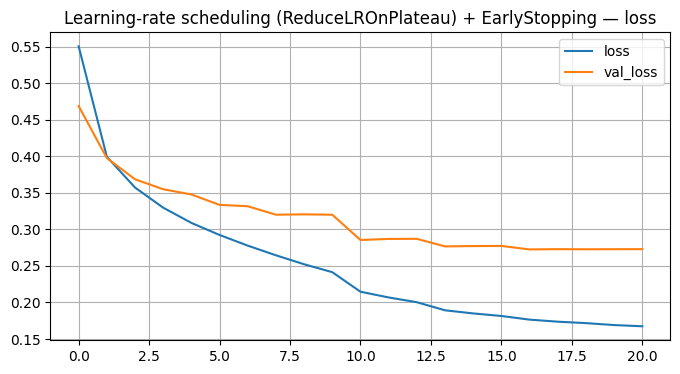

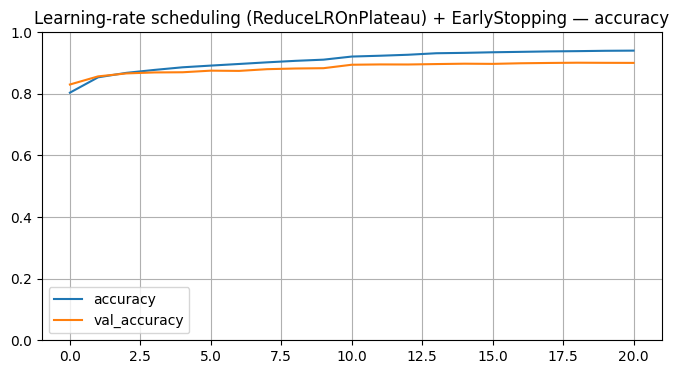

In [19]:
sched_model = build_baseline_classifier()

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

sched_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    metrics=["accuracy"]
)

sched_hist = sched_model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

plot_history(sched_hist, "Learning-rate scheduling (ReduceLROnPlateau) + EarlyStopping")

# Part H — Regularization for Deep Networks

## 12) Common regularization tools in deep nets
- **L2 weight decay**: penalizes large weights and often improves generalization.
- **Dropout**: randomly drops units during training, reducing co-adaptation.
- **Max-norm**: constrains weight norms to limit capacity.

Below I implement a simple model with L2 + Dropout.

Epoch 1/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7207 - loss: 0.8670 - val_accuracy: 0.8622 - val_loss: 0.4597
Epoch 2/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8337 - loss: 0.5322 - val_accuracy: 0.8688 - val_loss: 0.4294
Epoch 3/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8463 - loss: 0.4911 - val_accuracy: 0.8692 - val_loss: 0.4176
Epoch 4/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8548 - loss: 0.4641 - val_accuracy: 0.8820 - val_loss: 0.3995
Epoch 5/5
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8612 - loss: 0.4495 - val_accuracy: 0.8816 - val_loss: 0.4009


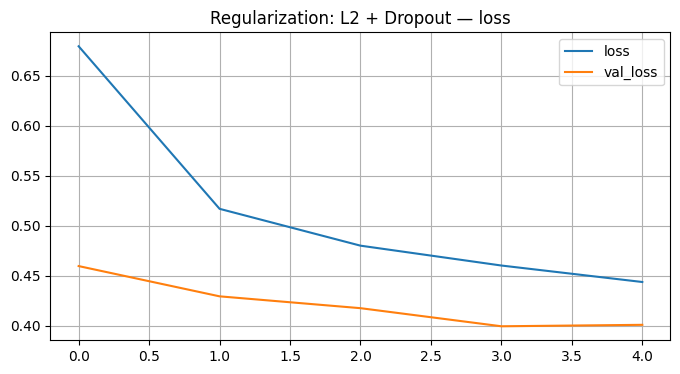

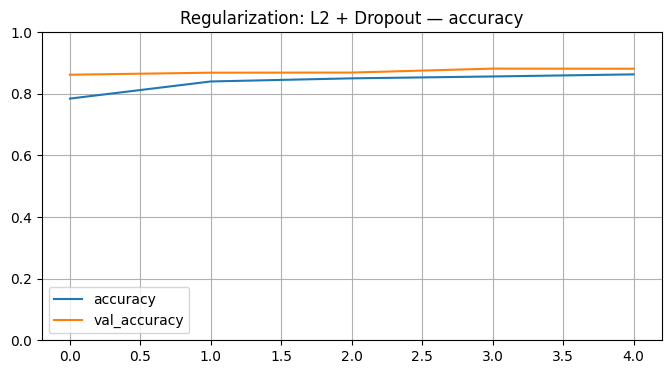

In [20]:
from tensorflow.keras import regularizers

reg_dropout_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation="relu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

hist_reg = compile_and_fit(
    reg_dropout_model, X_train, y_train, X_valid, y_valid,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    epochs=5,
    verbose=1
)

plot_history(hist_reg, "Regularization: L2 + Dropout")

## 13) Final evaluation snapshot
I evaluate a few representative models on the test set to ensure the notebook produces a final measurable outcome.

In [21]:
final_eval = []
final_eval.append({"model": "Deep sigmoid", **evaluate_model(sigmoid_model, X_test, y_test)})
final_eval.append({"model": "Deep ReLU+He", **evaluate_model(relu_he_model, X_test, y_test)})
final_eval.append({"model": "BatchNorm MLP", **evaluate_model(bn_model, X_test, y_test)})
final_eval.append({"model": "Regularized (L2+Dropout)", **evaluate_model(reg_dropout_model, X_test, y_test)})
pd.DataFrame(final_eval)

,model,test_loss,test_accuracy
0,Deep sigmoid,2.304263,0.1000
1,Deep ReLU+He,0.546825,0.7865
2,BatchNorm MLP,0.398480,0.8570
3,Regularized (L2+Dropout),0.444820,0.8642


## 14) Takeaways
- Deep networks can suffer from unstable or slow training due to vanishing/exploding gradients.
- Practical defaults:
  - **ReLU-family activations**,
  - **He initialization** for ReLU,
  - **Batch Normalization** to stabilize training,
  - **gradient clipping** to prevent exploding updates in some settings.
- Optimizers matter: SGD+momentum and Adam are common strong baselines.
- Learning-rate scheduling + early stopping is a practical workflow for stable training.
- Transfer learning workflow: freeze base → train head → unfreeze top layers → fine-tune with smaller LR.
- Regularization (L2, dropout, constraints) helps reduce overfitting when model capacity is large.

## 15) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 11.
- TensorFlow/Keras documentation: initializers, activations, BatchNormalization, callbacks, optimizers.